In [2]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230714-setup.csv')
domains_unique = dataset['domain'].unique()
for domain in domains_unique: print(domain)

libvirt_vm_count
libvirt_vm_cpu_cml
libvirt_vm_mem_cml
package-1
core-0
package-0
core-1
package-global
cpu%_package-global
cpu%_package-1
cpu%_package-0


# Global consumption

In [5]:
package_domains_watt = list()
for domain in domains_unique: 
    if domain.startswith('package-'): package_domains_watt.append(domain)

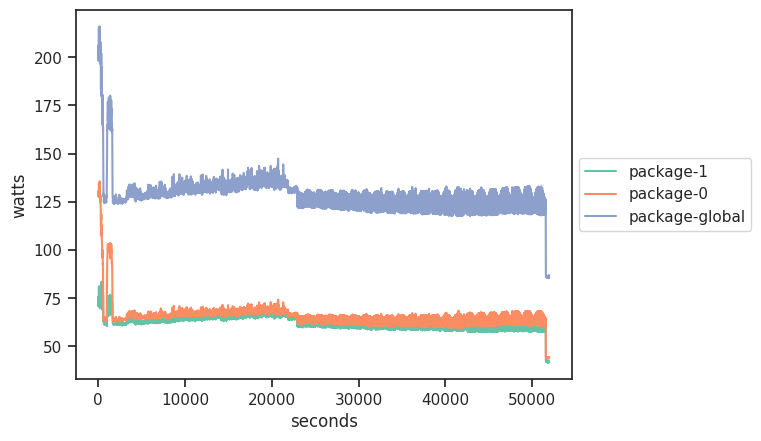

In [6]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))
ax = sns.lineplot(data=dataset.loc[dataset['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

# Global usage

On a multisocket environment, a socket being used at 100% is not at the same scale than the system being used at 100%. We therefore normalise it by the number of core being used

In [7]:
core_per_socket = 128
total_core = 256

In [8]:
package_domains_usage = list()
to_exclude = list()
for domain in domains_unique: 
    if domain.startswith('cpu%'): package_domains_usage.append(domain)
    else: to_exclude.append(domain)

usage_dataset = dataset.drop(dataset[dataset.domain.isin(to_exclude)].index)
usage_dataset['measure'] = usage_dataset.apply(lambda row : (row['measure']/100)*total_core if 'global' in row['domain'] else (row['measure']/100)*core_per_socket, axis=1)

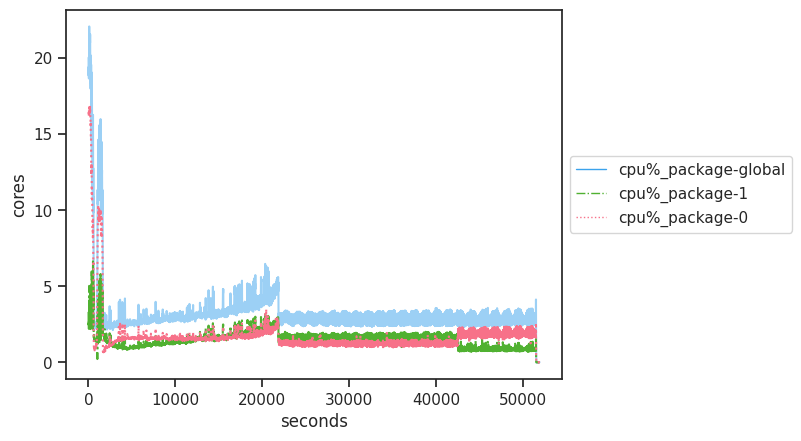

In [9]:
from matplotlib.lines import Line2D
sns.set_theme(style="ticks")
colors = list(sns.color_palette("husl", len(package_domains_usage)))
colors.reverse()
linestyles = ["-","-.",":","--"]
alpha = [0.5, 1 ,1, 1]

ax = plt.subplot()
package_domains_usage.sort(reverse=True)
handlers = list()
for index, domain in enumerate(package_domains_usage):
    filtered_dataset = usage_dataset.loc[usage_dataset['domain'] == domain]
    handlers.append(Line2D([0], [0], color=colors[index], linewidth=1, linestyle=linestyles[index]))
    sns.lineplot(data=filtered_dataset, x='timestamp', y='measure', color=colors[index], linestyle=linestyles[index], alpha=alpha[index], ax=ax, legend=None)

x = plt.legend(handlers, package_domains_usage, loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='cores')
plt.show()

# Link usage to consumption

In [10]:
dataset_labeled = dataset.copy()
dataset_labeled['label'] = dataset_labeled['domain'].apply(lambda name : name.replace('cpu%_', '') if 'package-' in name else None)
dataset_labeled.dropna(inplace=True)
labeled_domains_unique = dataset_labeled['domain'].unique()
labeled_label_unique   = dataset_labeled['label'].unique()

In [11]:
package_domains_watt  = list()
package_domains_usage = list()
for domain in labeled_domains_unique: 
    if domain.startswith('package-'): package_domains_watt.append(domain)
    if domain.startswith('cpu%'):     package_domains_usage.append(domain)

package_domains_usage = ['cpu%_package-global'] # To only display global usage
        
labeled_watt = dataset_labeled.loc[dataset_labeled['domain'].isin(package_domains_watt)]
labeled_usage = dataset_labeled.loc[dataset_labeled['domain'].isin(package_domains_usage)]

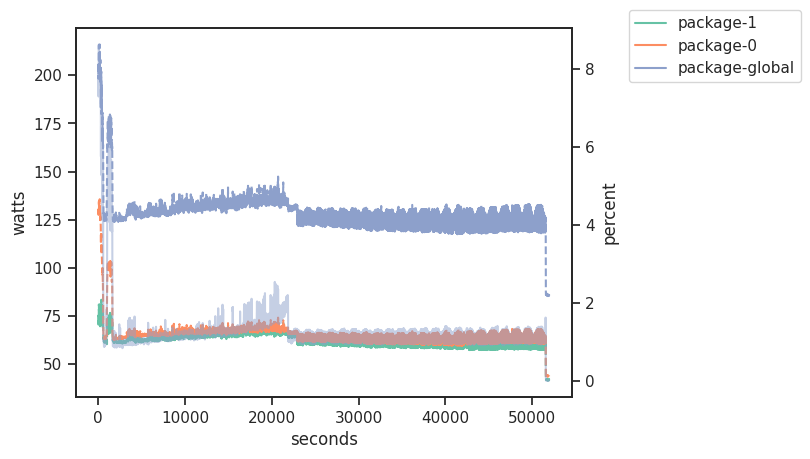

In [12]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(labeled_label_unique))

ax1  = sns.lineplot(data=labeled_watt, x='timestamp', y='measure', linestyle='--', hue='label', hue_order=labeled_label_unique, palette=palette)
ax1.set(xlabel='seconds', ylabel='watts')
ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.95))

ax2 = ax1.twinx()
sns.lineplot(data=labeled_usage, x='timestamp', y='measure', alpha  = 0.5, linestyle='-', hue='label', hue_order=labeled_label_unique, legend=False, palette=palette, ax=ax2)
g = ax2.set(ylabel='percent')

# Libvirt metrics

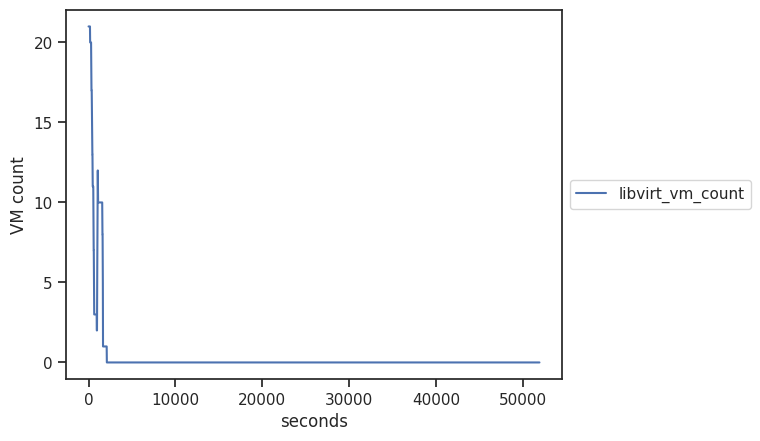

In [14]:
ax = sns.lineplot(data=dataset.loc[dataset['domain'] == 'libvirt_vm_count'], x='timestamp', y='measure', hue='domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='VM count')

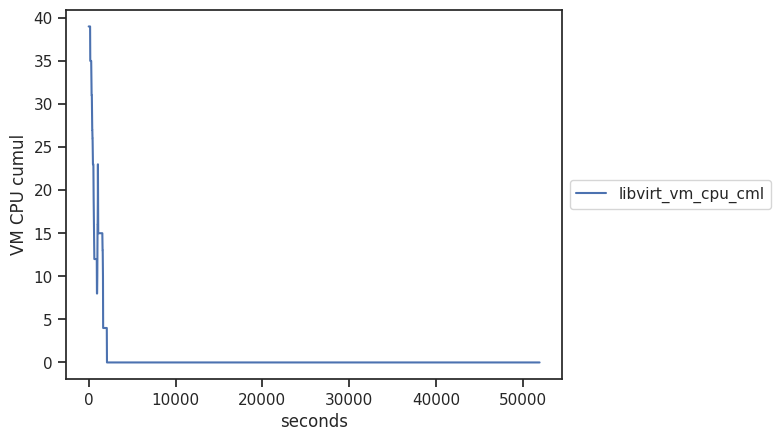

In [15]:
ax = sns.lineplot(data=dataset.loc[dataset['domain'] == 'libvirt_vm_cpu_cml'], x='timestamp', y='measure', hue='domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='VM CPU cumul')

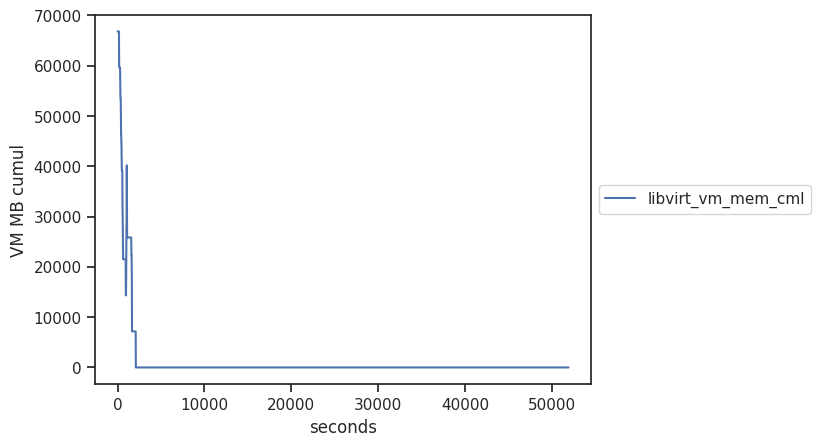

In [16]:
ax = sns.lineplot(data=dataset.loc[dataset['domain'] == 'libvirt_vm_mem_cml'], x='timestamp', y='measure', hue='domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='VM MB cumul')